<a href="https://colab.research.google.com/github/Chihiro-n/stockmodel/blob/master/LSTM_Stock_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NNで株価を予測モデルを作成する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# LSTMモデルを組む

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%pwd

'/content'

In [5]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [6]:
%ls

'Colaboratory へようこそ のコピー'
 data/
 data_dir/
 DogCat.ipynb
 kaggleデータinputの方法DogCat.ipynb
 keras_ssd_hands-on/
 LSTM_changed_dataset.ipynb
'LSTM_Stock_Classify (1).ipynb'
 LSTM_Stock_Classify.ipynb
 net.ckpt
 prophet/
'PyTorch実践入門ハンズオンセミナー配布用 のコピー'
 RNN_shapeCheak.ipynb
 RNN_sin_pred.ipynb
 sampleSubmission.csv
 torch_tuto_CFIA10.ipynb
 Youtube_Analysis_1.ipynb


# GPUセットのためのおまじない

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データセットを作る
### PytorchのLSTMに学習させるためのデータは次元の工夫が必要であり、二重リストにしないとエラーになる
### 訓練用とテスト用にデータを分ける。まず二重リストであるtmpを作ってからそれを分割した

In [8]:
window = 50   # データは日足

#csvfile = open('/content/drive/My Drive/data-text.csv', 'r', encoding='utf-8')
#df_train_law = pd.read_csv('./data/stock/label_difflog_2005-2018.csv' ,index_col=0)
df_train_law = pd.read_csv('./data/stock/class_label_difflog_2005-2018.csv' ,index_col=0)

df_train_law.head()

inp_dim = len(df_train_law)

train_endindex = int(inp_dim*0.9)



In [9]:
print(df_train_law.head())

              始値    高値    安値    終値  ...  label_m0  label_p0  label_p1  label_class
日付                                  ...                                           
2005-01-05  4210  4220  4140  4150  ...       0.0       0.0       0.0          0.0
2005-01-06  4150  4210  4150  4190  ...       1.0       0.0       0.0          2.0
2005-01-07  4210  4210  4140  4150  ...       0.0       1.0       0.0          3.0
2005-01-11  4180  4210  4170  4200  ...       1.0       0.0       0.0          2.0
2005-01-12  4180  4190  4140  4150  ...       0.0       1.0       0.0          3.0

[5 rows x 17 columns]


### inputデータとして、株価をlogに加工した値のみを取り出す。
最初の行だけは削除しておく。階差をlabelとしているため

In [10]:
df_input = df_train_law.iloc[:, 4:8 ]

#nd_cast = open.astype(np.float32)

In [11]:
df_input = df_input.drop('2005-01-05', axis=0)

In [12]:
df_input

,log始値,log高値,log安値,log終値
日付,,,,
2005-01-06,8.330864,8.345218,8.330864,8.340456
2005-01-07,8.345218,8.345218,8.328451,8.330864
2005-01-11,8.338067,8.345218,8.335671,8.342840
2005-01-12,8.338067,8.340456,8.328451,8.330864
2005-01-13,8.321178,8.328451,8.318742,8.323608
...,...,...,...,...
2018-12-21,8.777864,8.779096,8.764210,8.766550
2018-12-25,8.728264,8.733272,8.708805,8.712595
2018-12-26,8.720787,8.737934,8.706987,8.723557


### inputデータを作成する。
説明変数4つ　が 50日分.  
ループは50を引いておく  
numpyに変更しておく

In [13]:
#train_input = np.array([])
train_input = []

for i in range(len(df_input)-window):
  #train_input = np.append( train_input, df_input.iloc[i: i+window] )
  train_input.append( df_input.iloc[i: i+window].values )

### 中身チェック

In [14]:
print(len(train_input))
print(type(train_input))
#train_input[0]
#print(train_input.shape)


3366
<class 'list'>


### numpyに変更し、サイズもチェック

In [15]:
np_train_input = np.array(train_input)
np_train_input = np_train_input.astype(np.float32)  ### float型に変更しておかないと、modelに入力する際にerrorが出る　※doubleはNG

print(np_train_input.shape)

np_train_input


(3366, 50, 4)


array([[[8.330864 , 8.345218 , 8.330864 , 8.340456 ],
        [8.345218 , 8.345218 , 8.328451 , 8.330864 ],
        [8.338066 , 8.345218 , 8.335671 , 8.34284  ],
        ...,
        [8.308938 , 8.3113985, 8.304    , 8.3113985],
        [8.301521 , 8.306472 , 8.291547 , 8.294049 ],
        [8.296547 , 8.301521 , 8.294049 , 8.296547 ]],

       [[8.345218 , 8.345218 , 8.328451 , 8.330864 ],
        [8.338066 , 8.345218 , 8.335671 , 8.34284  ],
        [8.338066 , 8.340456 , 8.328451 , 8.330864 ],
        ...,
        [8.301521 , 8.306472 , 8.291547 , 8.294049 ],
        [8.296547 , 8.301521 , 8.294049 , 8.296547 ],
        [8.296547 , 8.301521 , 8.294049 , 8.294049 ]],

       [[8.338066 , 8.345218 , 8.335671 , 8.34284  ],
        [8.338066 , 8.340456 , 8.328451 , 8.330864 ],
        [8.321178 , 8.328451 , 8.318742 , 8.323608 ],
        ...,
        [8.296547 , 8.301521 , 8.294049 , 8.296547 ],
        [8.296547 , 8.301521 , 8.294049 , 8.294049 ],
        [8.296547 , 8.304    , 8.291547

# labelデータも numpyに変更しておく
labalはonehot vectorなので、(3366,1,4)になるはず 

In [16]:
df_label = df_train_law.iloc[:, 16 ]
df_label
#nd_cast = open.astype(np.float32)

日付
2005-01-05    0.0
2005-01-06    2.0
2005-01-07    3.0
2005-01-11    2.0
2005-01-12    3.0
             ... 
2018-12-21    1.0
2018-12-25    1.0
2018-12-26    2.0
2018-12-27    4.0
2018-12-28    2.0
Name: label_class, Length: 3417, dtype: float64

In [17]:
df_label = df_label.drop('2005-01-05', axis=0)

In [18]:
type(df_label)

pandas.core.series.Series

In [19]:
train_label = []

for i in range(len(df_label)-window):
  #train_label.append( df_label.iloc[window + i].values )
  train_label.append( df_label.iloc[window + i] )

In [20]:
np_train_label = np.array(train_label)
np_train_label = np_train_label.astype(np.float32)
np_train_label.shape

(3366,)

## Shapeを変更する、 二重リストの型へ


In [21]:
#np_train_label = np_train_label.reshape(-1,1)

In [22]:
print(np_train_label.shape)
print(np_train_label)


(3366,)
[3. 3. 2. ... 2. 4. 2.]


## TrainとTestで分割する

In [23]:
X_train, y_train, X_test, y_test= [], [], [], []


all_length = len(np_train_label)
train_length = int(all_length*0.9)

### 訓練用データセットを作成するループ
X_train = np_train_input[:train_length]
y_train = np_train_label[:train_length]

### テスト用データセットを作成するループ
X_test = np_train_input[train_length:]
y_test = np_train_label[train_length:]


In [24]:

print(inp_dim)
print( len(X_train[0]) )
print( len(X_train) )

print(X_train[0])
print(X_train[1])
print(X_train[2])

print("=================")
print(y_train[0])
print(y_train[1])

print("=================")
print( len(X_test[0]) )
print( len(X_test) )

print(X_test[0])
print(X_test[1])
print(X_test[2])
print("=================")
print(y_test[0])
print(y_test[1])

3417
50
3029
[[8.330864  8.345218  8.330864  8.340456 ]
 [8.345218  8.345218  8.328451  8.330864 ]
 [8.338066  8.345218  8.335671  8.34284  ]
 [8.338066  8.340456  8.328451  8.330864 ]
 [8.321178  8.328451  8.318742  8.323608 ]
 [8.318742  8.335671  8.313852  8.330864 ]
 [8.323608  8.33327   8.323608  8.323608 ]
 [8.328451  8.330864  8.3163    8.321178 ]
 [8.323608  8.328451  8.3163    8.3163   ]
 [8.3113985 8.313852  8.301521  8.304    ]
 [8.304     8.313852  8.301521  8.308938 ]
 [8.306472  8.308938  8.301521  8.304    ]
 [8.296547  8.299037  8.289037  8.291547 ]
 [8.306472  8.308938  8.301521  8.306472 ]
 [8.308938  8.308938  8.291547  8.296547 ]
 [8.299037  8.299037  8.283999  8.289037 ]
 [8.294049  8.301521  8.289037  8.301521 ]
 [8.306472  8.308938  8.296547  8.306472 ]
 [8.308938  8.3113985 8.301521  8.308938 ]
 [8.313852  8.313852  8.304     8.308938 ]
 [8.299037  8.306472  8.291547  8.306472 ]
 [8.304     8.308938  8.296547  8.306472 ]
 [8.313852  8.313852  8.308938  8.3113985

In [25]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(3029, 50, 4)
(3029,)
(337, 50, 4)
(337,)


### dataloader メソッドで、tensorに変更してくれるから必要なし

In [26]:
"""
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
"""

'\nX_train = torch.tensor(X_train)\ny_train = torch.tensor(y_train)\n\nX_test = torch.tensor(X_test)\ny_test = torch.tensor(y_test)\n'

## Dataを組むまでの流れ
1. Datasetクラスを作成する 
    1. 入力データと正解データにわける tensorにすること pd->np->tensorに変換する必要がある
    1. \__len__と\__getitem__を用意すること
1. Dataloaderを準備  
Datasetクラスで作ったやつをinputするだけなので難易度は低い
    

 ### datasetクラスを作成する

In [27]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,  X , y , mode='train' ,transform = None):
        self.data = X
        self.label = y
        self.num = len(X)
        self.mode= mode
        self.transform = transform
       
    
    def __len__(self):                         ###データの大きさをreturn するlenメソッドを必ず作成する必要がある
        return self.num
    
    def __getitem__(self, idx):           ###正解データと入力データが対となるようなgetitemメソッドを必ず作成する必要がある
        
        out_data = self.data[idx]
        out_label =  self.label[idx]
        
        return out_data, out_label
        

### XとyをDatasetクラスを継承させて作った自作クラスにinput

In [28]:
trainset = Dataset( X_train , y_train )

In [29]:
#trainset.shape
X_train.shape

(3029, 50, 4)

In [30]:
dataloader = torch.utils.data.DataLoader(dataset=trainset, batch_size = 32 , shuffle=True)

### 中身の確認
### dataloaderを使用したとしてもshapeは、(バッチ、timestep、説明変数次元)の順になる
dataloaderを使用すると、勝手にnumpy型からtorch型に変更されている。

In [31]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [32]:
print(X.shape)
print(len(X_train))
print(len(y_train))

torch.Size([32, 50, 4])
3029
3029


# モデルの構築
* input 層
* middle 層
* output 層

In [33]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        
        self.lstm = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
                           
        self.lstm_output_layer = nn.Linear(hiddenDim, outputDim)
        #self.sigmoid_out = nn.Linear(outputDim, 4)    # labelは one hotベクトルなので outputを4クラスに分けられるようにする
        #self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs, hidden0=None):
        #print(inputs) 　　　　# このinputsには1batchが入る。サイズが4なら 4 ,50, 1 
        output, (hidden, cell) = self.lstm(inputs, hidden0) #LSTM層
        output = self.lstm_output_layer(output[:, -1, :]) #全結合層
        #output = self.sigmoid_out(output)
        return output


In [34]:
#model = Predictor(4,64,4)    # inputの次元は? 株価onlyだから1次元となるのか、それとも時間を5個分とってくるから 5次元？？
model = Predictor(4,64,4).to(device)     ### 隠れ層は50で行う必要がある
model

Predictor(
  (lstm): LSTM(4, 64, batch_first=True)
  (lstm_output_layer): Linear(in_features=64, out_features=4, bias=True)
)

In [35]:
# 損失関数
#criterion = nn.MSELoss()      ### 損失化関数は二乗誤差を設定。　回帰モデルなのでOK
#criterion = nn.CrossEntropyLoss() #ソフトマックス交差エントロピー

criterion = nn.CrossEntropyLoss()



# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)     ### lrは学習率

In [36]:
loss_ = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(input.shape)
print(target)
print(target.shape)
#output_ = loss_(input, target)
#output_.backward()


tensor([[ 1.5111,  0.2742, -0.3929,  1.1774, -0.5191],
        [ 1.0709,  0.6026, -0.8633, -1.0736, -0.3859],
        [ 1.8409, -1.7354, -0.0603,  0.7213,  0.6835]], requires_grad=True)
torch.Size([3, 5])
tensor([2, 0, 0])
torch.Size([3])


# dataloaderを使った学習

In [37]:
ls_loss = []
model.train()


for epoch in range(30):
    
    model.train()
    for i, (X, label) in enumerate(dataloader):

        label = label.long()

        X_torch = X.to(device)
        label_torch = label.to(device)



        #print("X shape ",X_torch.shape)
        #print("label shape",label_torch.shape)
        #print("label",label_torch)
        

        label_torch = label_torch -1  ## なんの意味があるがよくわかっていないが、損失関数を計算するときにこれを入れないとエラーになる
                                      ## criterion()にて、 index error Target 4 is out of bounds


        # 勾配の初期化
        optimizer.zero_grad()     
        
        y_pred = model( X_torch )          ### ニューラルネットで計算したoutputを保存
        
        #print("y_pred : ",y_pred)
        #print("y_pred shape: ",y_pred.shape)

        loss = criterion(y_pred, label_torch) ###教師データとoutputから損失関数を計算
        

        # バッチごとのロスを記録する
        ls_loss.append(loss)
        
        # 勾配の計算
        loss.backward()           ### 損失関数を微分 = 勾配の計算
        
        # パラメータの更新
        optimizer.step()           
        
        #print('*** by optimizer.step()')
    

### ロスの確認 dataloader

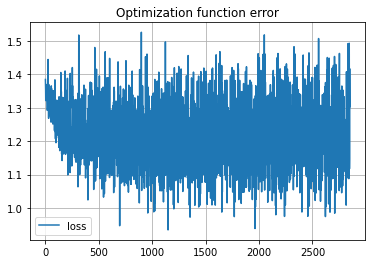

In [38]:
plt.figure()
plt.plot(ls_loss,label="loss")
plt.title('Optimization function error') # 最適化関数の誤差
plt.legend()
plt.grid()

## できあがったmodelでテストを行ってみる

In [39]:
testset = Dataset( X_test , y_test )
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size = 1, shuffle=True)

In [40]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [41]:

y_testresult = []
model.eval()
#t = np.arange(50, 58)



for i, (X, label) in enumerate(dataloader):

    print("@@@@@@@@@@@@", i)
    
    print(X)
    optimizer.zero_grad()
    
    y = model(X)
    l = label
    
    print("label",label)
    print(y)
    
    y = y.to('cpu').detach().numpy().copy()
    l = l.to('cpu').detach().numpy().copy()
    
    y_flat = y.flatten()
    l_flat = l.flatten()
    
"""    
    plt.plot(t,y_flat, marker = 'o')
    plt.plot(t,l_flat, marker = 'x')
    plt.show()
"""    

ストリーミング出力は最後の 5000 行に切り捨てられました。
         [8.8721, 8.8814, 8.8626, 8.8777],
         [8.8749, 8.8832, 8.8618, 8.8633],
         [8.8683, 8.8754, 8.8569, 8.8643],
         [8.8621, 8.8742, 8.8589, 8.8676],
         [8.8711, 8.8768, 8.8615, 8.8659],
         [8.8742, 8.8854, 8.8721, 8.8765],
         [8.8813, 8.8878, 8.8782, 8.8832],
         [8.8847, 8.8894, 8.8750, 8.8750],
         [8.8697, 8.8795, 8.8618, 8.8723],
         [8.8758, 8.8910, 8.8749, 8.8865],
         [8.8921, 8.8955, 8.8846, 8.8926],
         [8.8919, 8.9162, 8.8911, 8.9056],
         [8.9195, 8.9261, 8.9153, 8.9191],
         [8.9165, 8.9231, 8.9118, 8.9169],
         [8.9160, 8.9240, 8.9100, 8.9146]]])
label tensor([2.])
tensor([[-0.7884,  0.4684,  0.5880, -0.7903]], grad_fn=<AddmmBackward>)
@@@@@@@@@@@@ 243
tensor([[[8.8534, 8.8535, 8.8413, 8.8429],
         [8.8427, 8.8459, 8.8332, 8.8388],
         [8.8383, 8.8456, 8.8365, 8.8365],
         [8.8439, 8.8449, 8.8388, 8.8443],
         [8.8443, 8.8521, 8.8435, 8.8517]

"    \n    plt.plot(t,y_flat, marker = 'o')\n    plt.plot(t,l_flat, marker = 'x')\n    plt.show()\n"